In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, find_peaks, hilbert, welch, find_peaks
from scipy.integrate import cumtrapz
from scipy.stats import linregress, kurtosis
from numpy.fft import fft, fftfreq
import pywt
import os
import wfdb

In [44]:
def extract_features(signal, fs):
    mean = np.mean(signal)
    std = np.std(signal)
    amplitude = np.max(signal) - np.min(signal)
    fft_signal = np.fft.fft(signal)
    dominant_frequency = np.argmax(np.abs(fft_signal))
    peaks, _ = find_peaks(signal)
    duration = (peaks[-1] - peaks[0]) / len(signal) if peaks.size > 1 else 0
    power = np.sum(np.square(signal)) / len(signal)
    kurtosis_val = kurtosis(signal)
    coeffs = pywt.wavedec(signal, 'db4', level=5)
    wavelet = np.concatenate(coeffs)
    rms = np.sqrt(np.mean(signal**2))
    area = cumtrapz(signal, initial=0)[-1]
    f, P = welch(signal, fs=fs, window='hann', noverlap=0, nfft=256)
    area_freq = cumtrapz(P, f, initial=0)[-1]
    total_power = np.trapz(P, f)
    median_freq = f[np.where(np.cumsum(P) > total_power/2)[0][0]]
    f_max = f[np.argmax(P)]

    features = {
        'media': mean,
        'desviacion_estandar': std,
        'amplitud': amplitude,
        'frecuencia_dominante': dominant_frequency,
        'potencia': power,
        'kurtosis': kurtosis_val,
        'rms': rms,
        'area': area,
        'min_value': np.min(signal),
        'max_value': np.max(signal),
        'area_freq': area_freq,
        'total_power': total_power,
        'median_freq': median_freq,
        'f_max': f_max,
    }
    return features

In [45]:
def butter_bandpass(lowcut, highcut, fs, order=5, filter_type = "band"):
    return butter(order, [lowcut, highcut], fs=fs, btype=filter_type)

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, filter_tp = "band"):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order, filter_type = filter_tp)
    w, h = freqz(b, a, fs=fs, worN=2000)
    y = lfilter(b, a, data)
    return y,w,h

def fft(x,fs = None,n = None):
    X = np.fft.fftshift(np.fft.fft(x,n))
    N = len(X)
    k = np.arange(N)
    w = 2*np.pi*k/N
    w = np.fft.fftshift(w)
    w = np.unwrap(w - 2*np.pi)
    if fs != None:
        f = w*fs/(2*np.pi)
        return X,f,w
    else:
        return X,w

def extraer_nombres_archivos_dat(directorio):
    nombres_archivos_dat = []
    for raiz, dirs, archivos in os.walk(directorio):
        for archivo in archivos:
            if archivo.endswith('.dat'):
                nombres_archivos_dat.append(archivo[:-4])
    return nombres_archivos_dat

file_path = '../dataset/waves/'

names = extraer_nombres_archivos_dat(file_path)

7433
7433
7433


Text(0.5, 0, 'Tiempo (s)')

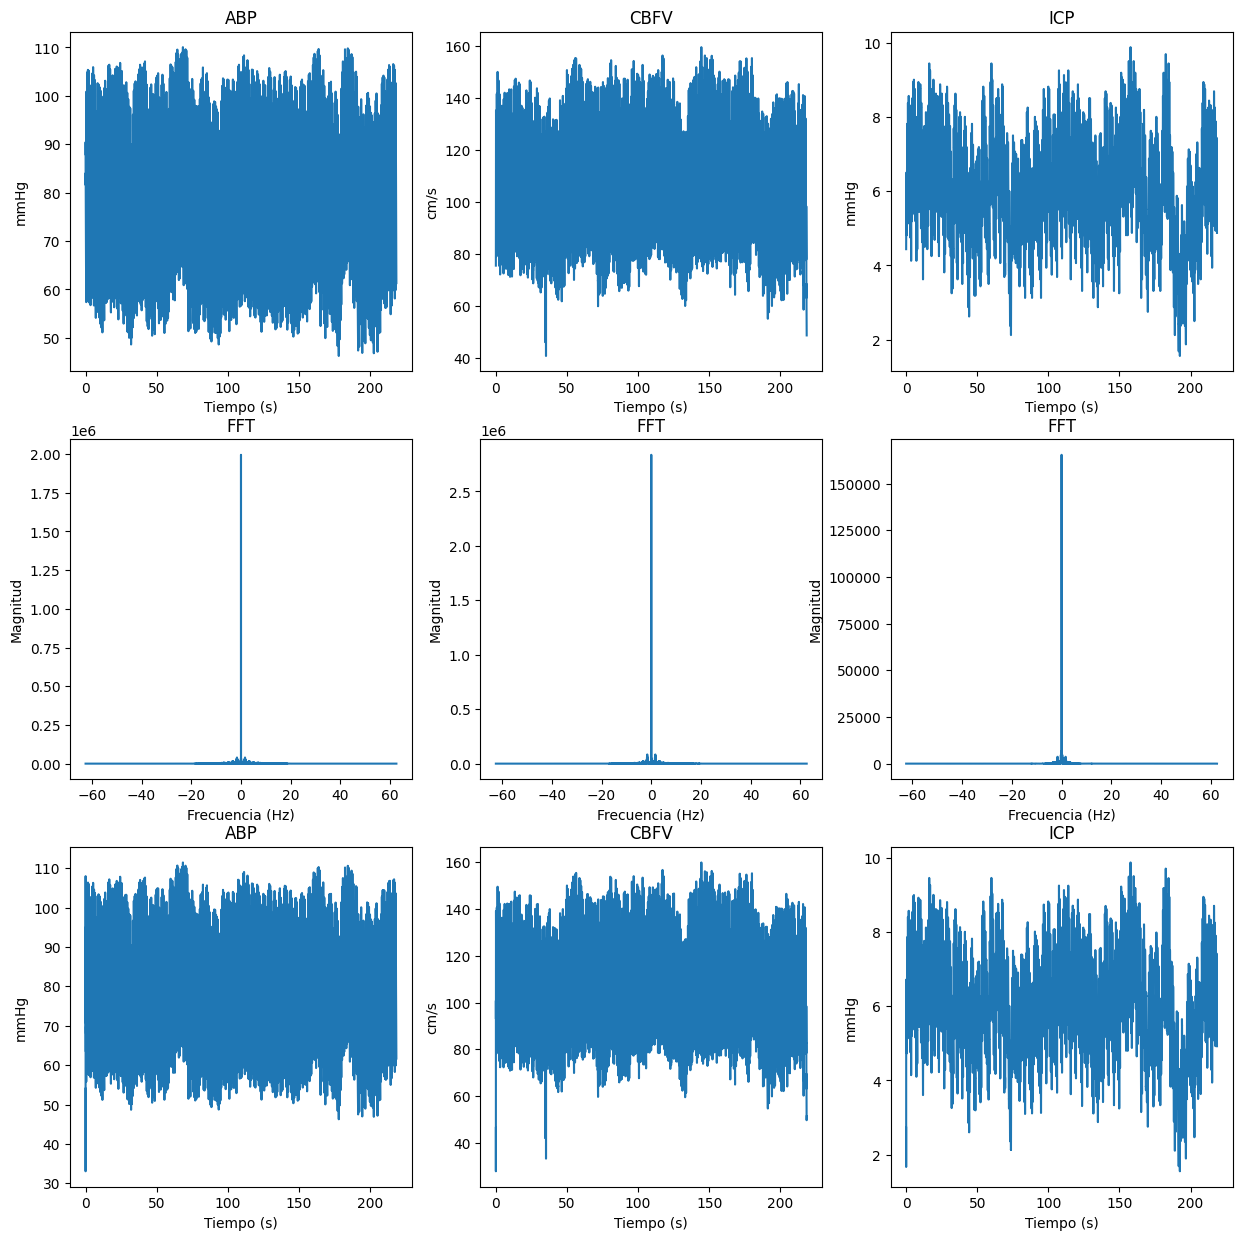

In [46]:
segm_dict = {"ABP":[],"CBFV": [] ,"ICP":[]}

for i, record_name in enumerate(names):
    path = '../dataset/waves/'
    record = wfdb.rdrecord(record_name=path+record_name)
    signal = record.p_signal
    cont = record.__dict__
    titles = cont["sig_name"]
    sig = cont["p_signal"]
    fs = cont["fs"]
    units = cont["units"]
    adc_gain = cont["adc_gain"]
    sig_l = cont["sig_len"]

    adj_sig = sig
    sig_dict = {titles[i]:adj_sig[:,i] for i in range(0,3)}
    units_dict = {titles[i]:units[i] for i in range(0,3)}

    filt_dict = {}
    for key, value in sig_dict.items():
        sig = value
        # sig = sig - np.mean(sig)
        filt_sig,_,_ = butter_bandpass_filter(sig, 0.5, 14.0, fs, order=6)
        filt_sig,_,_ = butter_bandpass_filter(sig, 20.0, 25.0, fs, order=6, filter_tp = 'stop')
        filt_dict[key] = filt_sig

    fft_dict = {}
    for key, value in filt_dict.items():
        sig = value
        X,f,w = fft(sig, fs)
        fft_dict[key] = X
    t_seg = 5
    N_seg = 5*fs

    for key, value in filt_dict.items():
        point = N_seg
        while point + N_seg < len(value):
            segm = value[point:point+N_seg]
            segm_dict[key].append(segm)
            point += N_seg
    
print(len(segm_dict["ABP"]))
print(len(segm_dict["ICP"]))
print(len(segm_dict["CBFV"]))

t = np.arange(0, sig_l/fs, 1/fs)

plt.figure(figsize=(15, 15))
plt.subplot(331)
plt.plot(t, sig_dict["ABP"])#;plt.xlim([10, 20])
plt.title("ABP");plt.ylabel(units_dict["ABP"]);plt.xlabel("Tiempo (s)")
plt.subplot(332)
plt.plot(t, sig_dict["CBFV"])#;plt.xlim([10, 20])
plt.title("CBFV");plt.ylabel(units_dict["CBFV"]);plt.xlabel("Tiempo (s)")
plt.subplot(333)
plt.plot(t, sig_dict["ICP"])#;plt.xlim([10, 20])
plt.title("ICP");plt.ylabel(units_dict["ICP"]);plt.xlabel("Tiempo (s)")

plt.subplot(334)
plt.plot(f, abs(fft_dict["ABP"]))
plt.title("FFT");plt.ylabel("Magnitud");plt.xlabel("Frecuencia (Hz)")
plt.subplot(335)
plt.plot(f, abs(fft_dict["CBFV"]))
plt.title("FFT");plt.ylabel("Magnitud");plt.xlabel("Frecuencia (Hz)")
plt.subplot(336)
plt.plot(f, abs(fft_dict["ICP"]))
plt.title("FFT");plt.ylabel("Magnitud");plt.xlabel("Frecuencia (Hz)")

plt.subplot(337)
plt.plot(t, filt_dict["ABP"])#;plt.xlim([10, 20])
plt.title("ABP");plt.ylabel(units_dict["ABP"]);plt.xlabel("Tiempo (s)")
plt.subplot(338)
plt.plot(t, filt_dict["CBFV"])#;plt.xlim([10, 20])
plt.title("CBFV");plt.ylabel(units_dict["CBFV"]);plt.xlabel("Tiempo (s)")
plt.subplot(339)
plt.plot(t, filt_dict["ICP"])#;plt.xlim([10, 20])
plt.title("ICP");plt.ylabel(units_dict["ICP"]);plt.xlabel("Tiempo (s)")



In [47]:
# Generar un DataFrame de características para cada señal
dataframes = []
for signal_type in ['ABP', 'ICP', 'CBFV']:
    # Lista para almacenar las características de cada segmento
    features_list = []
    # Extraer las características de cada segmento y almacenarlas en la lista
    for segment in segm_dict[signal_type]:
        features = extract_features(segment, fs=125)  # Reemplazar 250 con el valor real de fs
        features_list.append(features)
    # Crear un DataFrame a partir de la lista de características
    df = pd.DataFrame(features_list)
    # Agregar un prefijo a las columnas del DataFrame para identificar el tipo de señal
    df = df.add_prefix(f'{signal_type}_')
    # Agregar el DataFrame a la lista
    dataframes.append(df)

all_features_df = pd.concat(dataframes, axis=1)

all_features_df.head()

,ABP_media,ABP_desviacion_estandar,ABP_amplitud,ABP_frecuencia_dominante,ABP_potencia,ABP_kurtosis,ABP_rms,ABP_area,ABP_min_value,ABP_max_value,...,CBFV_potencia,CBFV_kurtosis,CBFV_rms,CBFV_area,CBFV_min_value,CBFV_max_value,CBFV_area_freq,CBFV_total_power,CBFV_median_freq,CBFV_f_max
0,66.641384,11.490724,41.191509,0,4573.110805,-0.732653,67.624780,41579.706283,51.247460,92.438969,...,5419.772792,-0.591529,73.619106,45539.388377,58.416044,100.340963,103.082489,103.082489,1.464844,1.464844
1,67.378961,11.442618,43.396668,0,4670.857826,-0.674359,68.343674,42036.470128,51.309134,94.705801,...,4863.423446,-0.451027,69.738250,43206.504424,53.294024,91.480309,76.491657,76.491657,1.464844,1.464844
2,67.687198,11.308102,42.445611,0,4709.429904,-0.479220,68.625286,42244.903575,52.422143,94.867754,...,4493.080148,-0.756046,67.030442,41508.721107,51.930298,91.102156,71.524231,71.524231,1.464844,1.464844
3,69.787074,12.080038,43.576012,0,5016.163021,-0.718562,70.824876,43551.610943,53.260290,96.836302,...,4609.897889,-0.949087,67.896229,42065.365305,51.899062,88.384547,63.225485,63.225485,1.464844,1.464844
4,70.764247,12.052009,44.466655,0,5152.829593,-0.346857,71.783212,44159.252744,54.970395,99.437050,...,4583.707867,-0.876140,67.703086,41961.854743,53.051526,86.246286,54.945855,54.945855,1.464844,1.464844


In [48]:
all_features_df.columns

Index(['ABP_media', 'ABP_desviacion_estandar', 'ABP_amplitud',
       'ABP_frecuencia_dominante', 'ABP_potencia', 'ABP_kurtosis', 'ABP_rms',
       'ABP_area', 'ABP_min_value', 'ABP_max_value', 'ABP_area_freq',
       'ABP_total_power', 'ABP_median_freq', 'ABP_f_max', 'ICP_media',
       'ICP_desviacion_estandar', 'ICP_amplitud', 'ICP_frecuencia_dominante',
       'ICP_potencia', 'ICP_kurtosis', 'ICP_rms', 'ICP_area', 'ICP_min_value',
       'ICP_max_value', 'ICP_area_freq', 'ICP_total_power', 'ICP_median_freq',
       'ICP_f_max', 'CBFV_media', 'CBFV_desviacion_estandar', 'CBFV_amplitud',
       'CBFV_frecuencia_dominante', 'CBFV_potencia', 'CBFV_kurtosis',
       'CBFV_rms', 'CBFV_area', 'CBFV_min_value', 'CBFV_max_value',
       'CBFV_area_freq', 'CBFV_total_power', 'CBFV_median_freq', 'CBFV_f_max'],
      dtype='object')

In [49]:
selected_columns = ['ICP_media', 'ICP_desviacion_estandar', 'ICP_amplitud', 'ICP_frecuencia_dominante',
       'ICP_potencia', 'ICP_kurtosis', 'ICP_rms', 'ICP_area', 'ICP_min_value',
       'ICP_max_value', 'ICP_area_freq', 'ICP_total_power', 'ICP_median_freq',
       'ICP_f_max']
new_df = all_features_df[selected_columns]
new_df

,ICP_media,ICP_desviacion_estandar,ICP_amplitud,ICP_frecuencia_dominante,ICP_potencia,ICP_kurtosis,ICP_rms,ICP_area,ICP_min_value,ICP_max_value,ICP_area_freq,ICP_total_power,ICP_median_freq,ICP_f_max
0,8.569152,0.132698,0.594657,0,73.447968,-0.694506,8.570179,5347.181231,8.299935,8.894592,0.015227,0.015227,1.464844,1.464844
1,8.529631,0.165327,0.713570,0,72.781942,-0.671665,8.531233,5322.369107,8.230040,8.943610,0.018360,0.018360,0.488281,0.488281
2,8.643947,0.118557,0.514556,0,74.731873,-0.786568,8.644760,5393.871692,8.423921,8.938477,0.014494,0.014494,1.464844,1.464844
3,8.536756,0.126640,0.521767,0,72.892249,-0.903737,8.537696,5326.930893,8.310472,8.832239,0.014214,0.014214,1.464844,1.464844
4,8.582357,0.161566,0.721631,0,73.682963,-0.608379,8.583878,5355.322578,8.234675,8.956305,0.012907,0.012907,1.464844,1.464844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,3.720582,1.115312,4.311086,0,15.086649,-0.908307,3.884154,2320.987820,1.550947,5.862033,0.913524,0.913524,0.488281,0.488281
7429,4.581266,1.283336,5.250346,0,22.634953,-0.672495,4.757621,2859.075914,1.894175,7.144521,0.732710,0.732710,1.464844,1.464844
7430,5.009783,1.072057,4.842809,0,26.247234,-0.715991,5.123205,3126.052457,2.467845,7.310654,0.761743,0.761743,0.976562,1.464844
7431,5.976722,1.341976,5.448244,0,37.522106,-0.590552,6.125529,3729.519626,3.499419,8.947663,0.934601,0.934601,1.464844,1.464844


-------------------------------Target: ICP_media-------------------------------
R^2 para la regresión lineal: 0.4169447599089392
R^2 para la regresión polinomial de grado 2: 0.7356997255207347
     Linear Regression  Polynomial Regression
MSE           9.005152               4.082056
MAE           2.257061               1.478692
------------------------Target: ICP_desviacion_estandar------------------------
R^2 para la regresión lineal: 0.40776211783555627
R^2 para la regresión polinomial de grado 2: 0.673551376882418
     Linear Regression  Polynomial Regression
MSE           0.662046               0.364928
MAE           0.610277               0.419440
------------------------------Target: ICP_amplitud------------------------------
R^2 para la regresión lineal: 0.387516608114601
R^2 para la regresión polinomial de grado 2: 0.6523259109090452
     Linear Regression  Polynomial Regression
MSE           9.458970               5.369352
MAE           2.326757               1.625086
-------

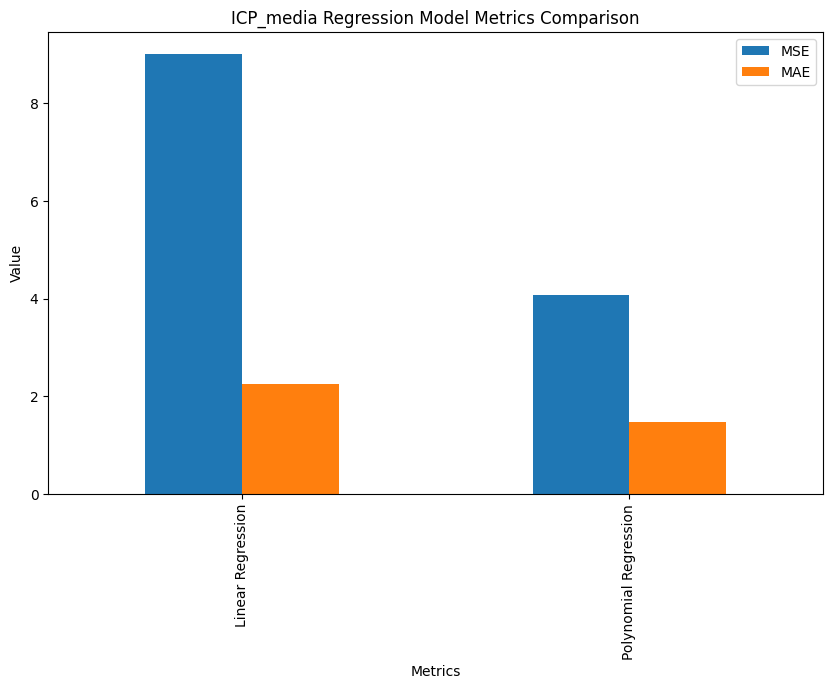

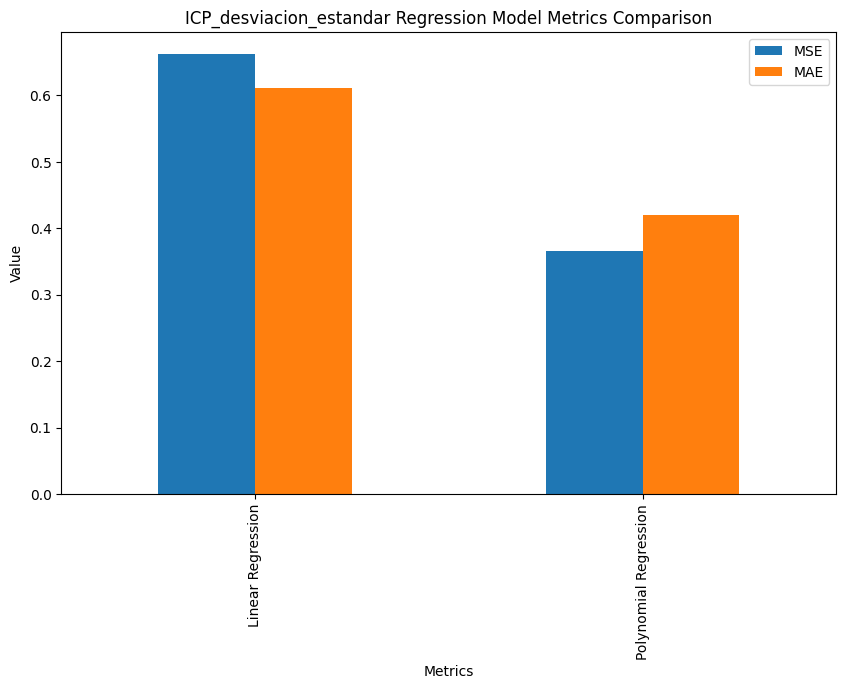

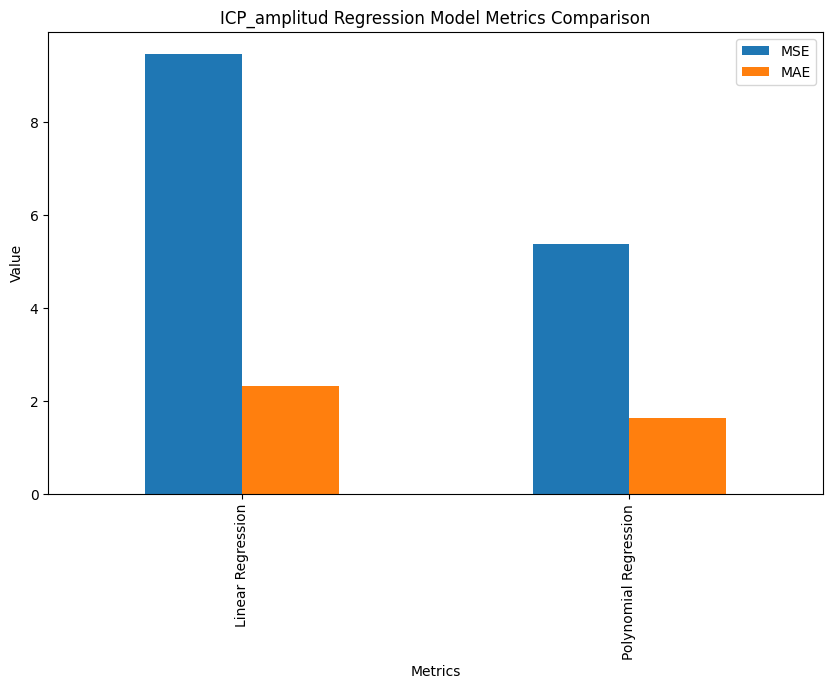

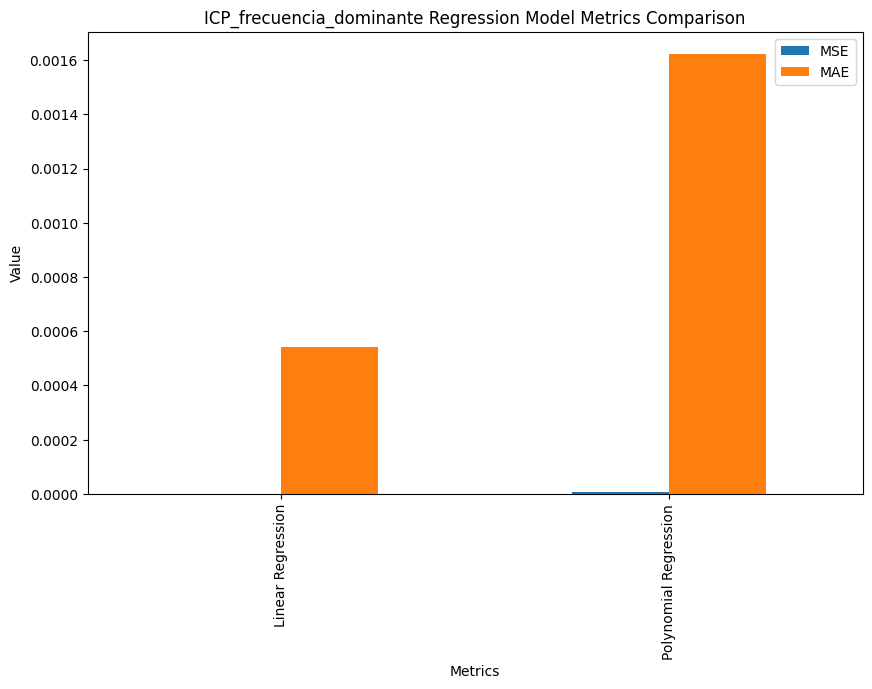

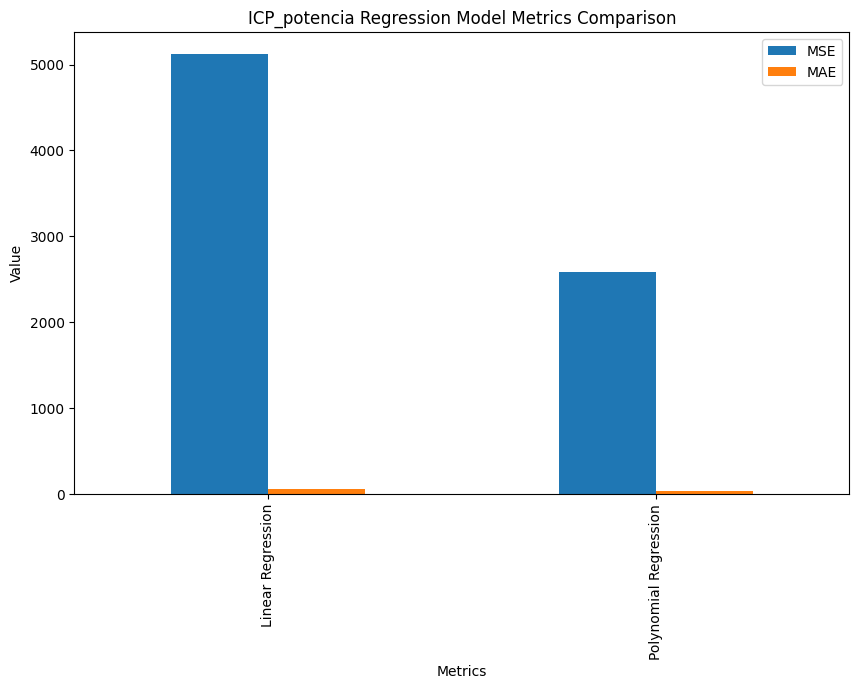

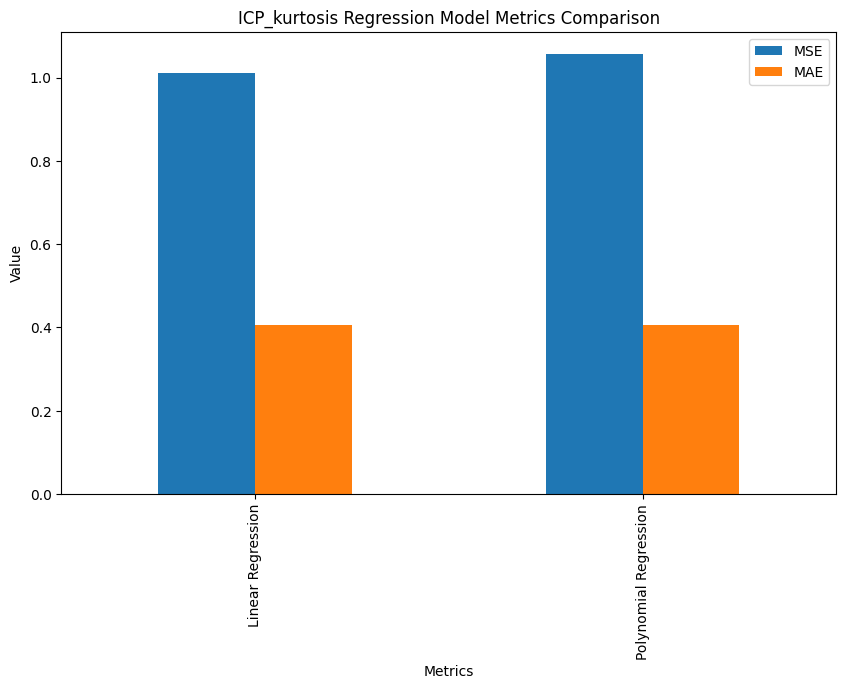

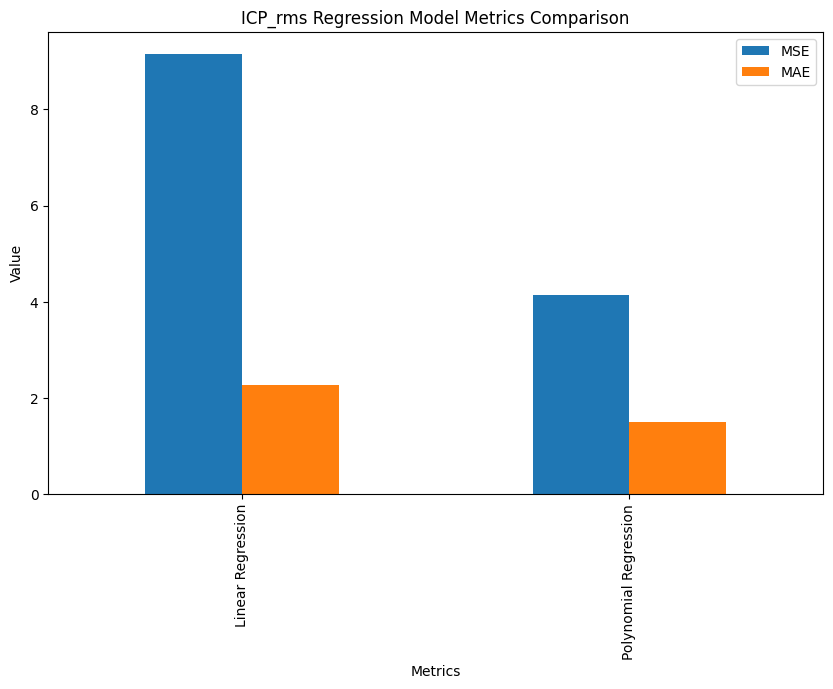

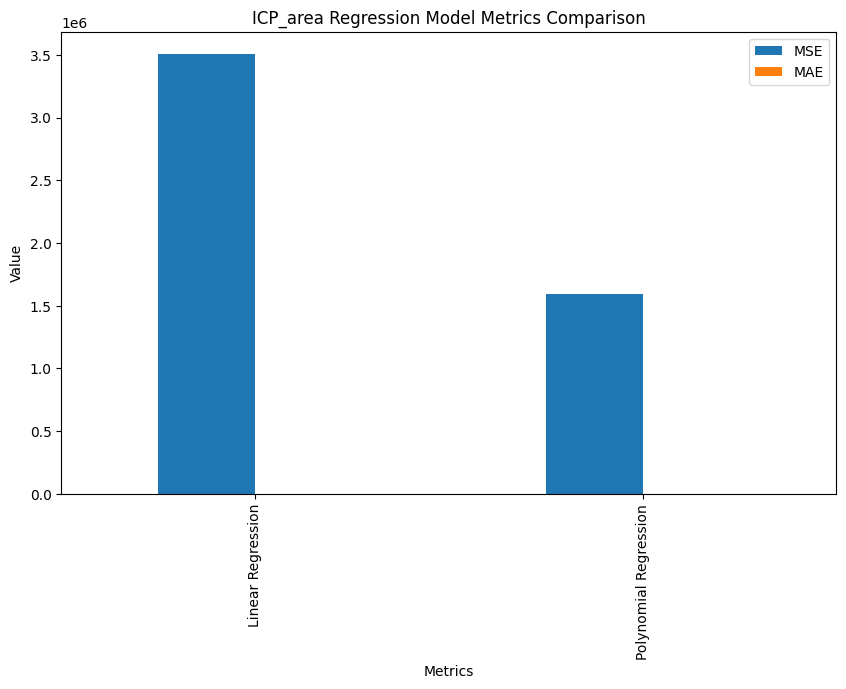

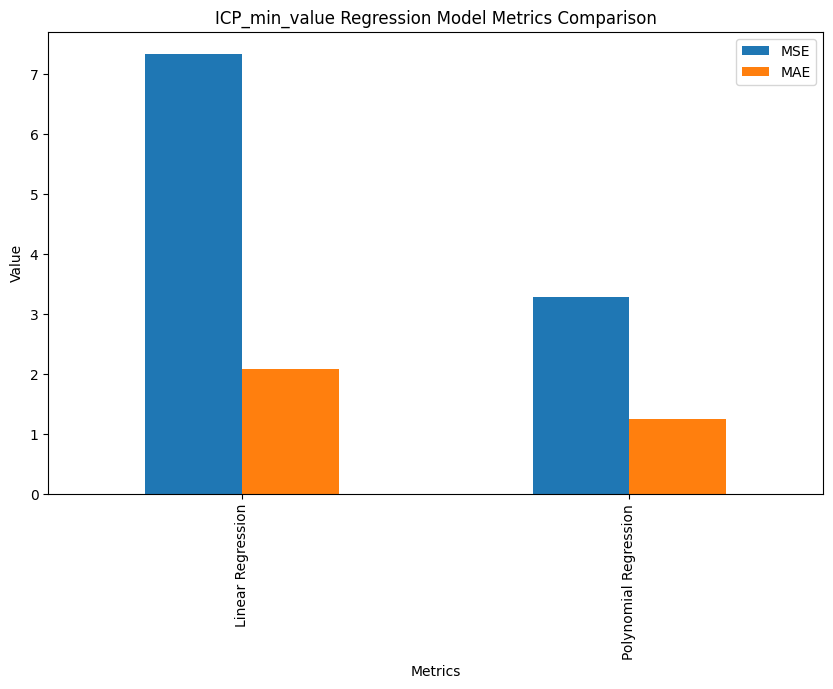

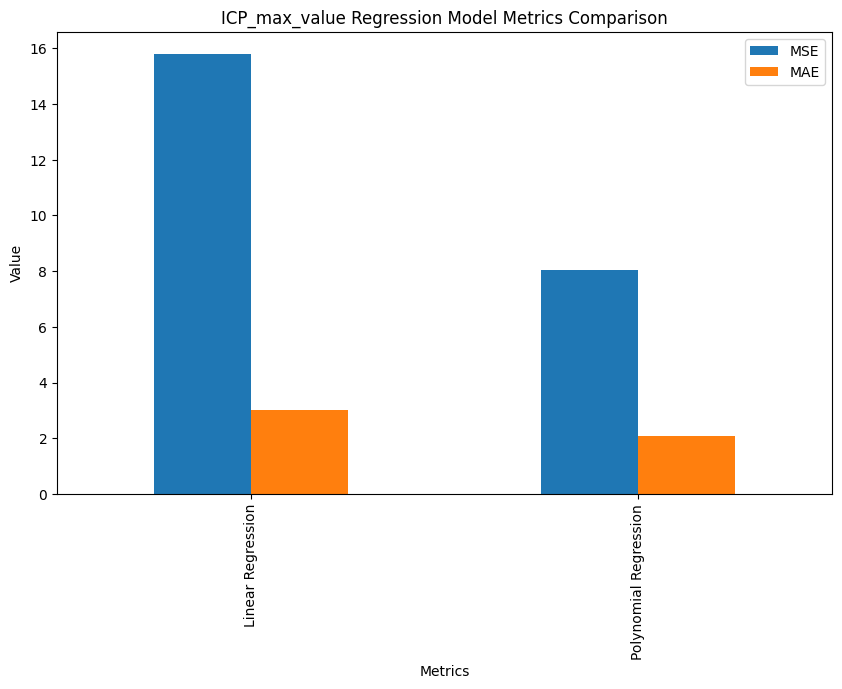

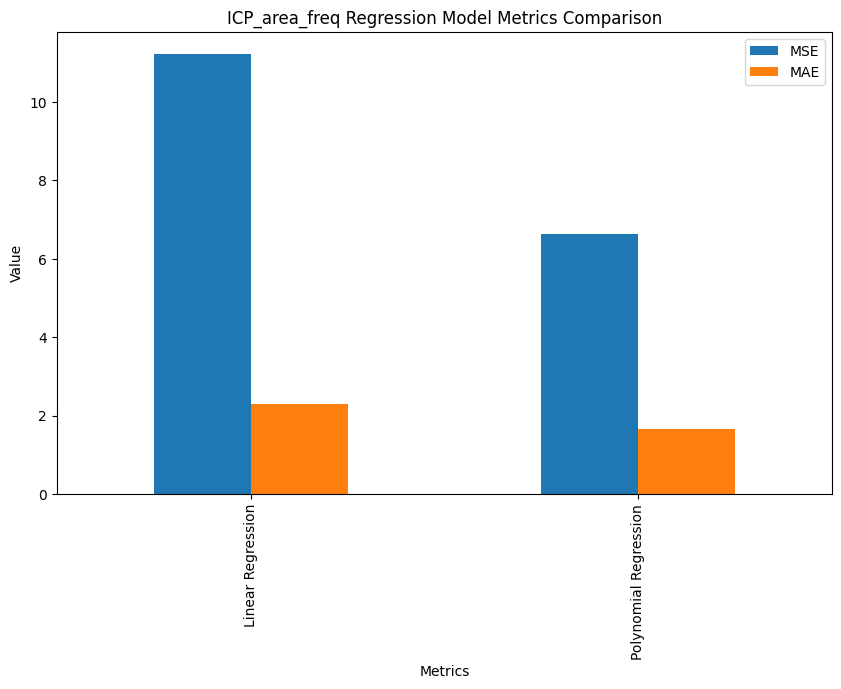

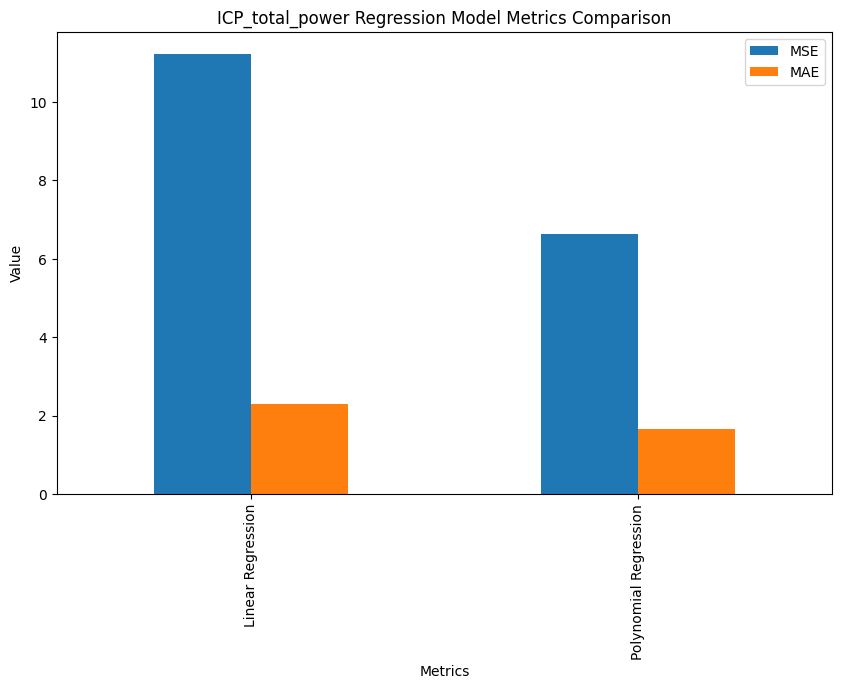

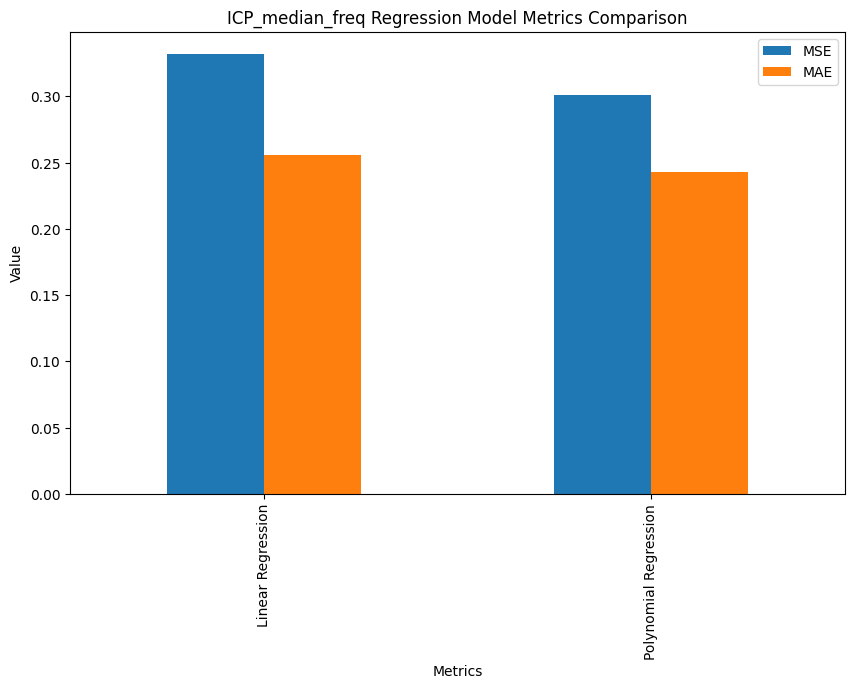

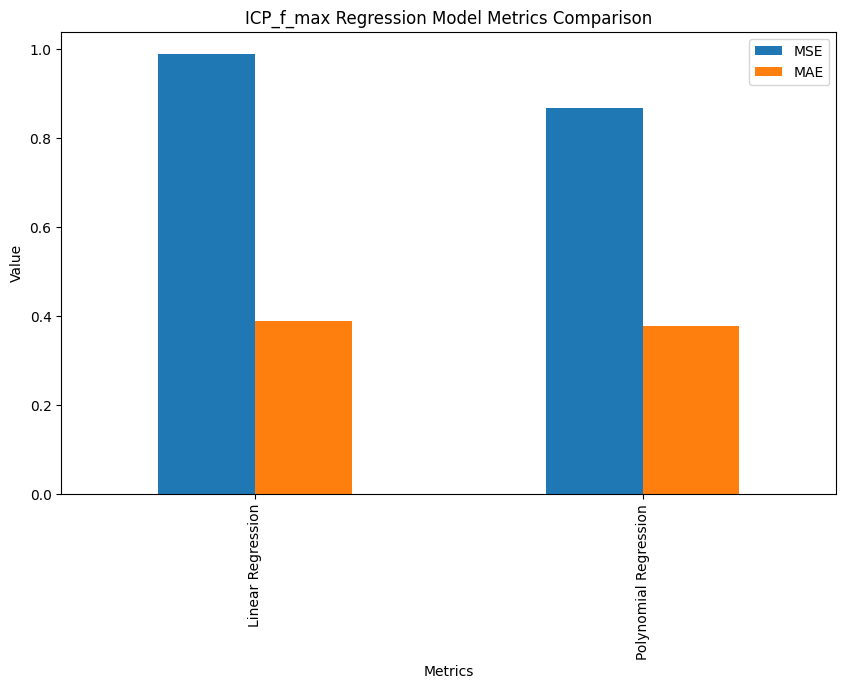

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

predictors = [col for col in all_features_df.columns if 'ABP_' in col or 'CBFV_' in col]

for target in selected_columns:
    id  = 'Target: ' + target
    spd = (80 - len(id))//2
    print(spd*'-' + id + spd*'-')
    # Dividimos los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(all_features_df[predictors], all_features_df[target], test_size=0.15, random_state=42)

    # Inicializamos y ajustamos el modelo de regresión lineal
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)

    # Predecimos sobre el conjunto de prueba
    y_pred_linear = linear_model.predict(X_test)

    # Calculamos el R^2 para la regresión lineal
    r2_linear = r2_score(y_test, y_pred_linear)
    print(f"R^2 para la regresión lineal: {r2_linear}")

    # Establecemos el grado del polinomio
    degree = 2

    # Creamos un modelo de regresión polinomial usando un pipeline
    polynomial_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    # Entrenamos el modelo polinomial
    polynomial_model.fit(X_train, y_train)

    # Predecimos sobre el conjunto de prueba
    y_pred_poly = polynomial_model.predict(X_test)

    # Calculamos el R^2 para la regresión polinomial
    r2_poly = r2_score(y_test, y_pred_poly)
    print(f"R^2 para la regresión polinomial de grado {degree}: {r2_poly}")

    # Calculate metrics for the linear regression model
    mse_linear = mean_squared_error(y_test, y_pred_linear)
    mae_linear = mean_absolute_error(y_test, y_pred_linear)

    # Calculate metrics for the polynomial regression model
    mse_poly = mean_squared_error(y_test, y_pred_poly)
    mae_poly = mean_absolute_error(y_test, y_pred_poly)

    # Create a DataFrame to display metrics
    metrics_df = pd.DataFrame({
        'Linear Regression': [mse_linear, mae_linear],
        'Polynomial Regression': [mse_poly, mae_poly]
    }, index=['MSE','MAE'])

    # Visualize the metrics for comparison
    metrics_plot = metrics_df.T.plot(kind='bar', figsize=(10, 6))
    metrics_plot.set_title(target + ' Regression Model Metrics Comparison')
    metrics_plot.set_ylabel('Value')
    metrics_plot.set_xlabel('Metrics')
    metrics_plot.figure.savefig('../Figures/' + target + '_regression_metrics_comparison.png')
    print(metrics_df)


### Selección de Características

Al decidir qué características utilizar para la regresión, se deben considerar los siguientes criterios:
- **Relevancia**: La característica debe tener una relevancia fisiológica con la condición o parámetro que se está prediciendo.
- **Poder Predictivo**: Las características con valores de \(R^2\) más altos y errores más bajos (MSE, MAE) indican un mayor poder predictivo.

Las características como **ICP_media**, **ICP_potencia**, **ICP_rms**, **ICP_area** y **ICP_max_value** muestran valores de \(R^2\) relativamente más altos en ambos modelos de regresión lineal y polinomial. Estas características también presentan valores de MSE y MAE más bajos en comparación con otros, lo que las convierte en candidatas prometedoras para la modelización predictiva.

### Método de Regresión

Comparando el rendimiento de la regresión lineal con la regresión polinomial (grado 2):
- **La Regresión Polinomial** generalmente supera en rendimiento a la regresión lineal en términos de valor de \(R^2\), MSE y MAE para la mayoría de los objetivos. Esto sugiere que la relación entre las características de entrada y las variables objetivo podría ser no lineal.
- **Excepción** en el objetivo **ICP_frecuencia_dominante**, donde tanto la regresión lineal como la polinomial tienen \(R^2 = 0.0\), indicando un ajuste pobre y posiblemente una relación lineal o cuadrática débil o inexistente con las características de entrada.

### Conclusiones

- **Utilizar la Regresión Polinomial** para las características donde esta supera significativamente a la regresión lineal, especialmente donde el valor de \(R^2\) es mucho más alto y los errores son sustancialmente más bajos. La relación no lineal capturada por la regresión polinomial parece alinearse mejor con los patrones subyacentes en los datos para estas características.
- **Considerar la Ingeniería de Características**: Para características con valores de \(R^2\) bajos en ambos modelos, considerar si la ingeniería de características adicional o la inclusión de términos de interacción podrían capturar la relación de manera más efectiva.
- **Evaluar la Complejidad del Modelo**: Aunque la regresión polinomial muestra un mejor rendimiento, es importante tener en cuenta el sobreajuste, especialmente con polinomios de grado superior. Las técnicas de regularización o estrategias de validación pueden ayudar a asegurar que el modelo generalice bien a nuevos datos.

En el proceso de análisis de los datos obtenidos, se evaluó la posibilidad de desarrollar un algoritmo de clasificación para distinguir entre pacientes con distintas condiciones. Sin embargo, este enfoque se encontró con limitaciones significativas que llevaron a la decisión de no proceder en esa dirección. Una de las principales restricciones fue la ausencia de datos de pacientes sanos en el conjunto de datos. Todos los pacientes incluidos presentaban diversas patologías, lo que dificultaba la definición de un grupo de control saludable para la clasificación. Además, la variabilidad temporal de los datos, que abarcaba un amplio intervalo de varias horas, introducía una complejidad adicional. Esta extensa gama temporal podía resultar en una variabilidad significativa dentro de los mismos grupos de patologías, complicando aún más cualquier intento de clasificación precisa. Por tanto, se determinó que un algoritmo de clasificación no sería el enfoque más adecuado dadas estas circunstancias, optando en su lugar por centrarse en la regresión y análisis predictivo que pudieran ofrecer insights valiosos a partir de las características y condiciones ya establecidas de los pacientes.